<h1><b>Car Driver Distraction</b></h1>

In [ ]:
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from google.colab.patches import cv2_imshow
from google.colab import output
import os

# Download dataset
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download state-farm-distracted-driver-detection
!unzip state-farm-distracted-driver-detection.zip
os.remove("state-farm-distracted-driver-detection.zip")

<h1><b>Pre-processing</b></h1>

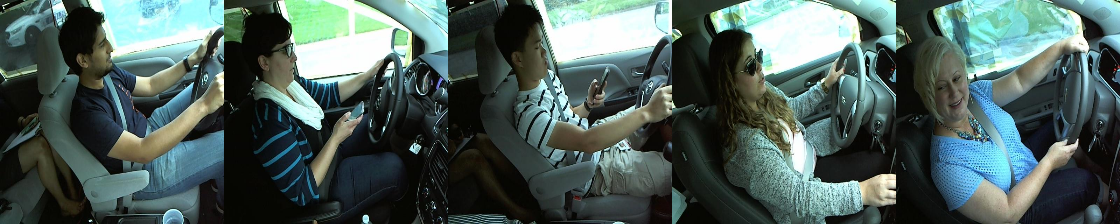

In [ ]:
# show random images
image1 = cv2.resize(cv2.imread("imgs/train/c0/img_17359.jpg").astype(np.float32), (224,224))
image2 = cv2.resize(cv2.imread("imgs/train/c1/img_10011.jpg").astype(np.float32), (224,224))
image3 = cv2.resize(cv2.imread("imgs/train/c3/img_10034.jpg").astype(np.float32), (224,224))
image4 = cv2.resize(cv2.imread("imgs/train/c5/img_100121.jpg").astype(np.float32), (224,224))
image5 = cv2.resize(cv2.imread("imgs/train/c9/img_100100.jpg").astype(np.float32), (224,224))
image = np.concatenate((image1, image2,image3,image4, image5), axis=1)
cv2_imshow(image)

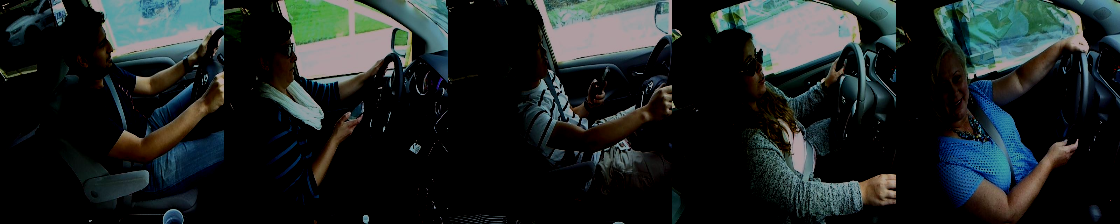

In [ ]:
# remove the mean value from the R G B channels -> make some important parts clearer
RGB_mean = np.mean(image, axis = (0,1))#mean
image[:, :, 0] = image[:, :, 0] - RGB_mean[0]
image[:, :, 1] = image[:, :, 1] - RGB_mean[1]
image[:, :, 2] = image[:, :, 2] - RGB_mean[2]
cv2_imshow(image)

    Total images 22424
    Training set 17939
    Test set 4485

In [ ]:
for i in range(0,10):
  src = "imgs/train/c"+str(i)+"/"
  list_images = os.listdir(src)
  os.makedirs("preprocessed_imgs/test/c"+str(i)+"/")
  for j in range(0,int((len(list_images)*20)/100)+1):
    #resize the image
    image = cv2.resize(cv2.imread(src+list_images[j]).astype(np.float32), (224, 224))
    #substract mean
    RGB_mean = np.mean(image, axis = (0,1))
    image[:, :, 0] = image[:, :, 0] - RGB_mean[0]
    image[:, :, 1] = image[:, :, 1] - RGB_mean[1]
    image[:, :, 2] = image[:, :, 2] - RGB_mean[2]
    #save image
    cv2.imwrite("preprocessed_imgs/test/c"+str(i)+"/"+list_images[j], image)
    os.remove("imgs/train/c"+str(i)+"/"+list_images[j])
!cp -r imgs/train preprocessed_imgs/
!rm -rf imgs

<h1><b>Classical deep CNN</b></h1>

In [ ]:
!pip install --upgrade tensorflow #use tensorflow 2.11.0
import tensorflow as tf
from tensorflow import keras #for building the model
from keras.models import Sequential
from keras import Input
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
import sklearn
from sklearn.metrics import classification_report #model evaluation metrics
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
output.clear()

In [ ]:
model_CNN = Sequential(name = "distracted-driver-CNN")#define model


#input layer
model_CNN.add(Input(shape = (224, 224, 3), name = "input-layer"))#specify shape of inputs

#1 convolution - MaxPooling - Dropout
model_CNN.add(Conv2D(filters = 16, #number of filter
                 kernel_size = (3,3), #filter matrix of size 3x3
                 activation = "relu", #relu activation is used
                 name = "2D-conv-layer-1"
                 ))

model_CNN.add(MaxPool2D(pool_size = (2,2), #filter size of 2x2
                    name = "2D-max-pool-layer-1"))

#model.add(Dropout(0.4, name="Dropout-layer-1"))


#2 convolution - MaxPooling - Dropout
model_CNN.add(Conv2D(filters = 32, #number of filter
                 kernel_size = (3,3), #filter matrix of size 3x3
                 activation = "relu", #relu activation is used
                 name = "2D-conv-layer-2"
                 ))

model_CNN.add(MaxPool2D(pool_size = (2,2), #filter size of 2x2
                    name = "2D-max-pool-layer-2"))

#model.add(Dropout(0.4, name="Dropout-layer-2"))


#3 convolution - MaxPooling - Dropout
model_CNN.add(Conv2D(filters = 32, #number of filter
                 kernel_size = (3,3), #filter matrix of size 3x3
                 activation = "relu", #relu activation is used
                 name = "2D-conv-layer-3"
                 ))

model_CNN.add(MaxPool2D(pool_size = (2,2), #filter size of 2x2
                    name = "2D-max-pool-layer-3"))

#model.add(Dropout(0.4, name="Dropout-layer-3"))


#4 convolution - MaxPooling - Dropout
model_CNN.add(Conv2D(filters = 64, #number of filter
                 kernel_size = (3,3), #filter matrix of size 3x3
                 activation = "relu", #relu activation is used
                 name = "2D-conv-layer-4"
                 ))

model_CNN.add(MaxPool2D(pool_size = (2,2), #filter size of 2x2
                    name = "2D-max-pool-layer-4"))


#model.add(Dropout(0.4, name="Dropout-layer-4"))



#feedforward layer + output layer
model_CNN.add(Flatten(name="Faltten-layer"))#flatten the shape

model_CNN.add(Dense(64, activation = "relu", name = "Hidden-layer-1"))
model_CNN.add(Dense(32, activation = "relu", name = "Hidden-layer-2"))

model_CNN.add(Dense(10, activation = "softmax", name = "Output-layer"))

model_CNN.summary()

# number of parameters is calculated :

  # (((kernel_size)*nbr_of_filters_previous_layer)+bias)*nbr_filters_current_layer

  # (((3*3)*3)+1)*16 = 448
  # pooling layer is automatic calculation there is no parameters to learn.

  # (((3*3)*16)+1)*32 = 4640
  # pooling layer is automatic calculation there is no parameters to learn.

  # (((3*3)*32)+1)*32 = 9248
  # pooling layer is automatic calculation there is no parameters to learn.

  # (((3*3)*32)+1)*64 = 18496
  # pooling layer is automatic calculation there is no parameters to learn.

  # Faltten-layer (Flatten)
  # ((9216 + 1)*64) = 589,888
  # ((64 + 1)*32) = 2080
  # ((32 + 1)*10) = 330

Model: "distracted-driver-CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 2D-conv-layer-1 (Conv2D)    (None, 222, 222, 16)      448       
                                                                 
 2D-max-pool-layer-1 (MaxPoo  (None, 111, 111, 16)     0         
 ling2D)                                                         
                                                                 
 2D-conv-layer-2 (Conv2D)    (None, 109, 109, 32)      4640      
                                                                 
 2D-max-pool-layer-2 (MaxPoo  (None, 54, 54, 32)       0         
 ling2D)                                                         
                                                                 
 2D-conv-layer-3 (Conv2D)    (None, 52, 52, 32)        9248      
                                                                 
 2D-max-pool-layer-3 (MaxPoo  (None, 26, 26, 

We compile the model and train it.

In [ ]:
#compile the model
lossfn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.AUTO, name='sparse_categorical_crossentropy')

model_CNN.compile(optimizer = "adam",
              loss = lossfn, #because we will provide classes as integers
              metrics = ['Accuracy'],
              )

#creates a flow from the train directory to avoid the memory problem
(train, validation) = tf.keras.preprocessing.image_dataset_from_directory("preprocessed_imgs/train",
                                                                      labels = 'inferred',
                                                                      image_size = (224, 224),
                                                                      batch_size = 32,
                                                                      subset = "both",
                                                                      label_mode = "int", #means that the labels are encoded as integers
                                                                      seed = 150,         #the seed is to make sure that there is no overlap between the training data and the validation subset
                                                                      validation_split = 0.1,
                                                                      )

AUTOTUNE = tf.data.AUTOTUNE
train = train.prefetch(buffer_size=AUTOTUNE)


early = EarlyStopping(monitor='val_Accuracy',      # parameter to monitor
                      min_delta=0.0001,            # Minimum change in the monitored quantity to qualify as an improvement
                      patience=3,                  # if no improvement in val_Accuracy after this number of epochs -> stop
                      verbose=1,                   # mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action
                      mode='max',                  # Stop in monitored value is not increasing
                      restore_best_weights=True)   # restore model weights from the epoch with the best value of the monitored quantity


#train the model
history_train_CNN = model_CNN.fit(x = train,
          epochs = 10,# train until val_Accuracy shows no developpement
          validation_data = validation,
          callbacks=([early])
          )

Found 17933 files belonging to 10 classes.
Using 16140 files for training.
Using 1793 files for validation.
Epoch 1/10
505/505 [==============================] - 59s 89ms/step - loss: 1.1465 - Accuracy: 0.6970 - val_loss: 0.2030 - val_Accuracy: 0.9381
Epoch 2/10
505/505 [==============================] - 36s 71ms/step - loss: 0.1203 - Accuracy: 0.9645 - val_loss: 0.0641 - val_Accuracy: 0.9788
Epoch 3/10
505/505 [==============================] - 36s 70ms/step - loss: 0.0717 - Accuracy: 0.9776 - val_loss: 0.0812 - val_Accuracy: 0.9749
Epoch 4/10
505/505 [==============================] - 36s 71ms/step - loss: 0.0476 - Accuracy: 0.9855 - val_loss: 0.0412 - val_Accuracy: 0.9888
Epoch 5/10
505/505 [==============================] - 36s 71ms/step - loss: 0.0456 - Accuracy: 0.9859 - val_loss: 0.0994 - val_Accuracy: 0.9743
Epoch 6/10
505/505 [==============================] - 36s 71ms/step - loss: 0.0407 - Accuracy: 0.9873 - val_loss: 0.0758 - val_Accuracy: 0.9816
Epoch 7/10
505/505 [========

In [ ]:
#creates a flow from the test directory to avoid the memory problem
test = tf.keras.preprocessing.image_dataset_from_directory("preprocessed_imgs/test",
                                                                      labels = 'inferred',
                                                                      image_size = (224, 224),
                                                                      batch_size = 32,
                                                                      shuffle = False,
                                                                      )

results_CNN = model_CNN.predict(test)

Found 4491 files belonging to 10 classes.
141/141 [==============================] - 36s 38ms/step


In [ ]:
#create a list of real test labels
real_labels = []
for i in range(0,10):
  imgs = os.listdir("preprocessed_imgs/test/c"+str(i))
  for j in range(0, len(imgs)):
    real_labels.append(i)

#transform test result datatype for confusion matrix
np.set_printoptions(threshold=np.inf)
results = pd.DataFrame(results_CNN, columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
results = results.idxmax(axis=1)# take the column that shows the highest value
predictions = pd.Series.tolist(results)

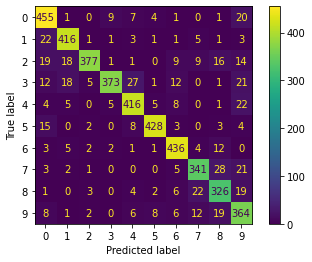

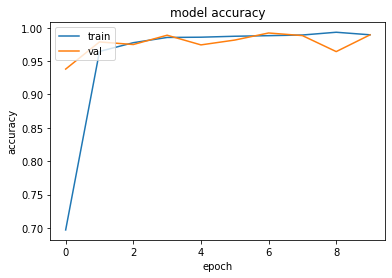

The accuracy of the test of the CNN is 0.88


In [ ]:
#confusion matrix and accuracy
from sklearn import metrics
cm = metrics.confusion_matrix(real_labels, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

cm_display.plot()
plt.show()

print("\n")

# training plot
plt.plot(history_train_CNN.history['Accuracy'])
plt.plot(history_train_CNN.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#calculate accuracy
sum=0
for i in range(0, 10):
  sum += cm[i,i]
print("The accuracy of the test of the CNN is " + str(round(sum/4491, 2)))

<h1><b>VGG16 Model</b></h1>

In [ ]:
!pip install --upgrade tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
output.clear()

In [ ]:
model_VGG16 = Sequential(name = "distracted-driver-VGG16")#define model

#input layer
model_VGG16.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))

#1 (1 x convolution) - MaxPooling
model_VGG16.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))

model_VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


#2 (2 x convolution) - MaxPooling
model_VGG16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

model_VGG16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

model_VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


#3 (3 x convolution) - MaxPooling
model_VGG16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

model_VGG16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

model_VGG16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

model_VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


#4 (3 x convolution) - MaxPooling
model_VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model_VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model_VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model_VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


#5 (3 x convolution) - MaxPooling
model_VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model_VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model_VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model_VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


#feedforward layer + output layer
model_VGG16.add(Flatten(name="Faltten-layer"))

model_VGG16.add(Dense(units=4096,activation="relu"))

model_VGG16.add(Dense(units=4096,activation="relu"))

model_VGG16.add(Dense(units=10, activation="softmax", name = "Output-layer"))

model_VGG16.summary()

# number of parameters is calculated :

  # (((kernel_size)*nbr_of_filters_previous_layer)+bias)*nbr_filters_current_layer

  # (((3*3)*3)+1)*64 = 1792
  # (((3*3)*64)+1)*64 = 36928
  # pooling layer is automatic calculation there is no parameters to learn.

  # (((3*3)*64)+1)*128 = 73856 (pooling layer has bias two)
  # (((3*3)*128)+1)*128 = 147584
  # pooling layer is automatic calculation there is no parameters to learn.

  # .....

  # Faltten-layer (Flatten)
  # ((25088 + 1)*4096) = 102,764,544
  # ((4096 + 1)*4096) = 16,781,312

Model: "distracted-driver-VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                       

In [ ]:
#compile the model
lossfn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=False, reduction=tf.keras.losses.Reduction.AUTO, name='sparse_categorical_crossentropy')

model_VGG16.compile(optimizer = "adam",
              loss = lossfn, #because we will provide classes as integers
              metrics = ['Accuracy'],
              )

#creates a flow from the train directory to avoid the memory problem
(train, validation) = tf.keras.preprocessing.image_dataset_from_directory("preprocessed_imgs/train",
                                                                      labels = 'inferred',
                                                                      image_size = (224, 224),
                                                                      batch_size = 32,
                                                                      subset = "both",
                                                                      label_mode = "int", #means that the labels are encoded as integers
                                                                      seed = 150,         #the seed is to make sure that there is no overlap between the training data and the validation subset
                                                                      validation_split = 0.1,
                                                                      )

AUTOTUNE = tf.data.AUTOTUNE
train = train.prefetch(buffer_size=AUTOTUNE)


early = EarlyStopping(monitor='val_Accuracy',      # parameter to monitor
                      min_delta=0.0001,            # Minimum change in the monitored quantity to qualify as an improvement
                      patience=3,                  # if no improvement in val_Accuracy after this number of epochs -> stop
                      verbose=1,                   # mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action
                      mode='max',                  # Stop in monitored value is not increasing
                      restore_best_weights=True)   # restore model weights from the epoch with the best value of the monitored quantity

#train the model
history_train_VGG16 = model_VGG16.fit(x = train,
          epochs = 10,# train until val_Accuracy shows no developpement
          validation_data = validation,
          callbacks=([early])
          )

Found 17933 files belonging to 10 classes.
Using 16140 files for training.
Using 1793 files for validation.
Epoch 1/10
505/505 [==============================] - 234s 453ms/step - loss: 20.0804 - Accuracy: 0.4475 - val_loss: 0.6778 - val_Accuracy: 0.7897
Epoch 2/10
505/505 [==============================] - 227s 449ms/step - loss: 0.3832 - Accuracy: 0.8800 - val_loss: 0.3523 - val_Accuracy: 0.9030
Epoch 3/10
505/505 [==============================] - 226s 447ms/step - loss: 0.1778 - Accuracy: 0.9462 - val_loss: 0.2007 - val_Accuracy: 0.9548
Epoch 4/10
505/505 [==============================] - 226s 446ms/step - loss: 0.1313 - Accuracy: 0.9612 - val_loss: 0.1977 - val_Accuracy: 0.9487
Epoch 5/10
505/505 [==============================] - 226s 446ms/step - loss: 0.0734 - Accuracy: 0.9763 - val_loss: 0.1538 - val_Accuracy: 0.9721
Epoch 6/10
505/505 [==============================] - 225s 446ms/step - loss: 0.0970 - Accuracy: 0.9712 - val_loss: 0.1109 - val_Accuracy: 0.9721
Epoch 7/10
505/

In [ ]:
#creates a flow from the test directory to avoid the memory problem
test = tf.keras.preprocessing.image_dataset_from_directory("preprocessed_imgs/test",
                                                                      labels = 'inferred',
                                                                      image_size = (224, 224),
                                                                      batch_size = 32,
                                                                      shuffle = False,
                                                                      )

results_VGG16 = model_VGG16.predict(test)

Found 4491 files belonging to 10 classes.
141/141 [==============================] - 23s 161ms/step


In [ ]:
#create a list of real test labels
real_labels = []
for i in range(0,10):
  imgs = os.listdir("preprocessed_imgs/test/c"+str(i))
  for j in range(0, len(imgs)):
    real_labels.append(i)

#transform test result datatype for confusion matrix
np.set_printoptions(threshold=np.inf)
results = pd.DataFrame(results_VGG16, columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
results = results.idxmax(axis=1) # take the column that shows the highest value
predictions = pd.Series.tolist(results)

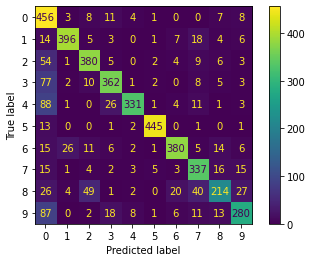

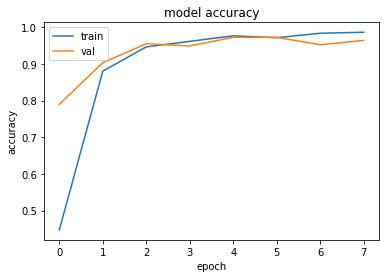

The accuracy of the test of the VGG-16 is 0.8


In [ ]:
#confusion matrix and accuracy
from sklearn import metrics
cm = metrics.confusion_matrix(real_labels, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

cm_display.plot()
plt.show()

print("\n")

# training plot
plt.plot(history_train_VGG16.history['Accuracy'])
plt.plot(history_train_VGG16.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


#calculate accuracy
sum=0
for i in range(0, 10):
  sum += cm[i,i]
print("The accuracy of the test of the VGG-16 is " + str(round(sum/4491, 2)))

<h1><b>Models with/withou Transfer Learning.</b></h1>


In this part you chose one of many models with/without Transfer learning.


In [ ]:
!pip install --upgrade tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
output.clear()

In [ ]:
if 'final_model' in locals():
  del final_model


print('''Chose a number :

1- VGG-19       2- ResNet101

3- ResNet50     4- ResNet50-V2

5- MobileNet    6- MobileNet-V2

''')

model_choice = input('Module Number : ')
transfer_learning = input('Use Transfer Learning ? (0 or 1)')

if(int(model_choice) < 1 or int(model_choice) > 6 or not(isinstance(model_choice, int) or (transfer_learning != 0 and transfer_learning != 1))):
   print('Invalid choices')
   exit()

Chose a number :

1- VGG-19       2- ResNet101

3- ResNet50     4- ResNet50-V2

5- MobileNet    6- MobileNet-V2




In [ ]:
from keras.applications import VGG19, ResNet101, ResNet50, ResNet50V2, MobileNet, MobileNetV2
from keras.models import Model
import keras

if(model_choice == '1'):
  print("VGG-19")
  initial_model = VGG19(include_top=False,                                      # Boolean, whether to include the fully-connected layer at the top of the network.
                  weights= 'imagenet' if transfer_learning == '1' else None,      # What type of wights to load, None -> random
                  input_shape=(224,224,3)
                  )
if(model_choice == '2'):
  print("ResNet101")
  initial_model = ResNet101(include_top=False, weights= 'imagenet' if transfer_learning == '1' else None, input_shape=(224,224,3))
if(model_choice == '3'):
  print("ResNet50")
  initial_model = ResNet50(include_top=False, weights= 'imagenet' if transfer_learning == '1' else None, input_shape=(224,224,3))
if(model_choice == '4'):
  print("ResNet50-V2")
  initial_model = ResNet50V2(include_top=False, weights= 'imagenet' if transfer_learning == '1' else None, input_shape=(224,224,3))
if(model_choice == '5'):
  print("MobileNet")
  initial_model = MobileNet(include_top=False, weights= 'imagenet' if transfer_learning == '1' else None, input_shape=(224,224,3))
if(model_choice == '6'):
  print("MobileNet-V2")
  initial_model = MobileNetV2(include_top=False, weights= 'imagenet' if transfer_learning == '1' else None, input_shape=(224,224,3))

output = initial_model.layers[-1].output
output = keras.layers.Flatten()(output)
initial_model = Model(initial_model.input, output)

for layer in initial_model.layers:
    layer.trainable = False

initial_model.summary()

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers


final_model = Sequential()
final_model.add(initial_model)
final_model.add(Dense(512, activation='relu', input_dim=(224,224,3)))
final_model.add(Dropout(0.3))
final_model.add(Dense(512, activation='relu'))
final_model.add(Dropout(0.3))
final_model.add(Dense(10, activation='sigmoid'))

final_model.summary()

In [ ]:
#compile the model
lossfn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=False, reduction=tf.keras.losses.Reduction.AUTO, name='sparse_categorical_crossentropy')

final_model.compile(optimizer = "adam",
              loss = lossfn,
              metrics = ['Accuracy'],
              )


#creates a flow from the train directory to avoid the memory problem
(train, validation) = tf.keras.preprocessing.image_dataset_from_directory("preprocessed_imgs/train",
                                                                      labels = 'inferred',
                                                                      image_size = (224, 224),
                                                                      batch_size = 32,
                                                                      subset = "both",
                                                                      label_mode = "int", #means that the labels are encoded as integers
                                                                      seed = 150,         #the seed is to make sure that there is no overlap between the training data and the validation subset
                                                                      validation_split = 0.1,
                                                                      )

AUTOTUNE = tf.data.AUTOTUNE
train = train.prefetch(buffer_size=AUTOTUNE)


early = EarlyStopping(monitor='val_Accuracy',      # parameter to monitor
                      min_delta=0.0001,            # Minimum change in the monitored quantity to qualify as an improvement
                      patience=3,                  # if no improvement in val_Accuracy after this number of epochs -> stop
                      verbose=1,                   # mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action
                      mode='max',                  # Stop in monitored value is not increasing
                      restore_best_weights=True)   # restore model weights from the epoch with the best value of the monitored quantity

#train the model
history_train_FINAL_MODEL = final_model.fit(x = train,
          epochs = 10,# train until val_Accuracy shows no developpement
          validation_data = validation,
          callbacks=([early])
          )

In [ ]:
#creates a flow from the test directory to avoid the memory problem
test = tf.keras.preprocessing.image_dataset_from_directory("preprocessed_imgs/test",
                                                                      labels = 'inferred',
                                                                      image_size = (224, 224),
                                                                      batch_size = 32,
                                                                      shuffle = False,
                                                                      )

results_FINAL_MODEL = final_model.predict(test)

In [ ]:
#create a list of real test labels
real_labels = []
for i in range(0,10):
  imgs = os.listdir("preprocessed_imgs/test/c"+str(i))
  for j in range(0, len(imgs)):
    real_labels.append(i)

#transform test result datatype for confusion matrix
np.set_printoptions(threshold=np.inf)
results = pd.DataFrame(results_FINAL_MODEL, columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
results = results.idxmax(axis=1) # take the column that shows the highest value
predictions = pd.Series.tolist(results)

In [ ]:
#confusion matrix and accuracy
from sklearn import metrics
cm = metrics.confusion_matrix(real_labels, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

cm_display.plot()
plt.show()

print("\n")

# training plot
plt.plot(history_train_FINAL_MODEL.history['Accuracy'])
plt.plot(history_train_FINAL_MODEL.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


#calculate accuracy
sum=0
for i in range(0, 10):
  sum += cm[i,i]
print("The accuracy of the test of the model number "+model_choice+" is " + str(round(sum/4491, 2)))